In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import os
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tylergehbauer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
#tokenization for wordcloud, ect..
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [34]:
#used for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [77]:
#reports
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [3]:
#reads in the dataset
imdb_df = pd.read_csv("Data/IMDB Dataset.csv")

In [4]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
#This loops creates a vader sentiment score for each review
sentiments = []#creates empty list

#Going to use VADER’s SentimentIntensityAnalyzer() to see how many 'Neutral (neu)' , 'Positive (pos)', and 'Negatvie(neg)'
# words there are for each review. 
for review in imdb_df['review']: #goes through each review in dataframe and applies polarity
    try:
        text = review #accessing each review in dataframe
        results = analyzer.polarity_scores(text) #this is how get compound, pos, neg, and nue polarity scores
        #during imports we set analyzer equal to SentimentIntensityAnalyzer() 
        #'results' uses this function to find polarity score for each article in bitcoin_news
        compound = results["compound"] #gets compound polarity score
        pos = results["pos"] #gets postive polarity score
        neu = results["neu"] #gets neutral polarity score
        neg = results["neg"] #gets negative polarity score

        sentiments.append({
            "text": text,
            "Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu,
        }) #appends a dictionary inside the list-(sentiments) so a dataframe can be created
        #this appends all polarity score we got above
    except AttributeError:
        pass
#rinse and repeat for each article    
imdb = pd.DataFrame(sentiments) #creates a dataframe using the list of dicts
imdb.head()

,text,Compound,Positive,Negative,Neutral
0,One of the other reviewers has mentioned that ...,-0.9951,0.048,0.203,0.748
1,A wonderful little production. <br /><br />The...,0.9641,0.172,0.053,0.776
2,I thought this was a wonderful way to spend ti...,0.9605,0.192,0.094,0.714
3,Basically there's a family where a little boy ...,-0.9213,0.065,0.138,0.797
4,"Petter Mattei's ""Love in the Time of Money"" is...",0.9744,0.147,0.052,0.801


In [7]:
imdb.tail(5)

,text,Compound,Positive,Negative,Neutral
49995,I thought this movie did a down right good job...,0.9890,0.199,0.047,0.753
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",-0.6693,0.114,0.166,0.720
49997,I am a Catholic taught in parochial elementary...,-0.9851,0.108,0.208,0.683
49998,I'm going to have to disagree with the previou...,-0.7648,0.082,0.105,0.813
49999,No one expects the Star Trek movies to be high...,0.4329,0.141,0.135,0.723


In [8]:
# Instantiate the lemmatizer
wnl = WordNetLemmatizer() 

# Create a list of stopwords
stop = stopwords.words('english') # contains all stop words for english

In [9]:
# Expand the default stopwords list if necessary
#will append each word to the list 'stop' created in cell above.
stop.append("u")
stop.append("it'")
stop.append("'s")
stop.append("n't")
stop.append('…')
stop.append("\`")
stop.append('``')
stop.append('char')
stop.append('chars')
stop.append("''")
stop.append('’')
stop.append('arent')
stop.append('Mr.')
stop.append(',')
stop.append('br')
stop.append('film')
stop.append('movie')
stop.append('say')
stop.append('get')
stop.append('would')
stop.append('could')
stop.append('people')
stop.append('guy')
stop.append('put')
stop.append('given')
stop.append('go')
stop.append('one')
stop.append('even')
stop.append('also')
stop.append("'m")

stop = set(stop)

In [10]:
# Complete the tokenizer function
#function that creates the 'tokens' column
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text) #tokenizes each word in text

    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))
    
    # Remove the stopwords
    words = list(filter(lambda t: t.lower() not in stop, words)) #uses the stop list we created
    
    # Lemmatize Words into root words
    #makes Ran and Running into same word for exmaple. 
    tokens = [wnl.lemmatize(word) for word in words]
    
    return tokens

In [11]:
# Create a new tokens column for each words in review
imdb["tokens"] = imdb.text.apply(tokenizer)
imdb.head()

,text,Compound,Positive,Negative,Neutral,tokens
0,One of the other reviewers has mentioned that ...,-0.9951,0.048,0.203,0.748,"[reviewer, mentioned, watching, 1, Oz, episode..."
1,A wonderful little production. <br /><br />The...,0.9641,0.172,0.053,0.776,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,0.9605,0.192,0.094,0.714,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,-0.9213,0.065,0.138,0.797,"[Basically, family, little, boy, Jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",0.9744,0.147,0.052,0.801,"[Petter, Mattei, Love, Time, Money, visually, ..."


In [12]:
#looks at mean score for each column
imdb.describe()

,Compound,Positive,Negative,Neutral
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.299203,0.140736,0.094630,0.764636
std,0.806077,0.066568,0.058763,0.069129
min,-0.999800,0.000000,0.000000,0.336000
25%,-0.690100,0.094000,0.052000,0.722000
50%,0.820150,0.131000,0.087000,0.768000
75%,0.970500,0.177000,0.130000,0.812000
max,0.999900,0.548000,0.580000,1.000000


## LSTM Algoirthm

In [16]:
#Joins the original 'sentiiment' column to the updated dataframe (for algorithm)
machine_imdb = imdb.join(imdb_df['sentiment'])
machine_imdb.head()

,text,Compound,Positive,Negative,Neutral,tokens,sentiment
0,One of the other reviewers has mentioned that ...,-0.9951,0.048,0.203,0.748,"[reviewer, mentioned, watching, 1, Oz, episode...",positive
1,A wonderful little production. <br /><br />The...,0.9641,0.172,0.053,0.776,"[wonderful, little, production, filming, techn...",positive
2,I thought this was a wonderful way to spend ti...,0.9605,0.192,0.094,0.714,"[thought, wonderful, way, spend, time, hot, su...",positive
3,Basically there's a family where a little boy ...,-0.9213,0.065,0.138,0.797,"[Basically, family, little, boy, Jake, think, ...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",0.9744,0.147,0.052,0.801,"[Petter, Mattei, Love, Time, Money, visually, ...",positive


In [14]:
#this will change 'postive' and 'negative' into integer, necessary for LSTM 
sentiments_dict = {
    'positive': 1,
    'negative': 0
}

In [35]:
#this applies the dict just created to the dataframe
machine_imdb['sentiment'] = machine_imdb['sentiment'].apply(lambda x: sentiments_dict[x])
machine_imdb.head(5)

,text,Compound,Positive,Negative,Neutral,tokens,sentiment
0,One of the other reviewers has mentioned that ...,-0.9951,0.048,0.203,0.748,"[reviewer, mentioned, watching, 1, Oz, episode...",1
1,A wonderful little production. <br /><br />The...,0.9641,0.172,0.053,0.776,"[wonderful, little, production, filming, techn...",1
2,I thought this was a wonderful way to spend ti...,0.9605,0.192,0.094,0.714,"[thought, wonderful, way, spend, time, hot, su...",1
3,Basically there's a family where a little boy ...,-0.9213,0.065,0.138,0.797,"[Basically, family, little, boy, Jake, think, ...",0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0.9744,0.147,0.052,0.801,"[Petter, Mattei, Love, Time, Money, visually, ...",1


In [36]:
y = machine_imdb['sentiment'].values #y equals this specific column (target)/ what you want to predict
X = machine_imdb['tokens'].values #x is all columnes without Outcome (features)/ what you will use to predict
#seperates the columns

In [37]:
#makes all tokens same size so can train model
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(machine_imdb['tokens'])

In [38]:
#We replace the words in our sentences with whichever index they are included in the 'tokenizer'
X_seq = tokenizer.texts_to_sequences(X)
#transform the text data to numerical sequences and save the sequences in a variable called X_seq

In [93]:
# Set the pad size
max_words = 150 #max a (whole comment) segment will be less than 150 to normalize

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq, maxlen=max_words, padding="post", truncating='post') #truncating='post'

pad_sequences: This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, random_state=78)

Verify Shape

In [95]:
X_test.shape

(12500, 150)

In [96]:
X_train.shape

(37500, 150)

You should set the input_dim parameter to the size of your vocabulary, so we set the vocabulary_size variable to the length of the number of words in the tokenizer plus 1

In [97]:
vocabulary_size = len(tokenizer.word_counts.keys()) + 1 #used to find the length of the vector made
embedding_size = 64

In [102]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=128))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [103]:
#compiles model
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [104]:
# Show the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 64)           10109568  
                                                                 
 lstm_11 (LSTM)              (None, 128)               98816     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,208,513
Trainable params: 10,208,513
Non-trainable params: 0
_________________________________________________________________


In [105]:
#fits model
model.fit(X_train, y_train, batch_size = 1000, epochs = 10, verbose = 1) 

Epoch 1/10
38/38 [==============================] - 47s 1s/step - loss: 0.6919 - accuracy: 0.5103
Epoch 2/10
38/38 [==============================] - 41s 1s/step - loss: 0.4362 - accuracy: 0.8132
Epoch 3/10
38/38 [==============================] - 40s 1s/step - loss: 0.1953 - accuracy: 0.9347
Epoch 4/10
38/38 [==============================] - 41s 1s/step - loss: 0.0964 - accuracy: 0.9727
Epoch 5/10
38/38 [==============================] - 41s 1s/step - loss: 0.0560 - accuracy: 0.9869
Epoch 6/10
38/38 [==============================] - 41s 1s/step - loss: 0.0441 - accuracy: 0.9914
Epoch 7/10
38/38 [==============================] - 40s 1s/step - loss: 0.0318 - accuracy: 0.9941
Epoch 8/10
38/38 [==============================] - 41s 1s/step - loss: 0.0345 - accuracy: 0.9928
Epoch 9/10
38/38 [==============================] - 41s 1s/step - loss: 0.0315 - accuracy: 0.9938
Epoch 10/10
38/38 [==============================] - 42s 1s/step - loss: 0.0544 - accuracy: 0.9892


In [106]:
# Evaluate the model
model.evaluate(X_test, y_test)

391/391 [==============================] - 10s 24ms/step - loss: 0.4763 - accuracy: 0.8520


[0.4763362407684326, 0.8519999980926514]

In [107]:
predictions = model.predict(X_test)
predictions

array([[0.94529295],
       [0.87517965],
       [0.00525647],
       ...,
       [0.00409794],
       [0.00408337],
       [0.00408345]], dtype=float32)

In [220]:
y_pred = model.predict(X_test) > 0.7 #anything greater than .7 is considered 1 (positive) - gave best results

In [221]:
y_test = np.reshape(y_test, (-1,1)) #this makes it so y_test is one dimension

In [222]:
prediction_df = pd.DataFrame({"Actual": y_test.ravel() , "Prediction": y_pred.ravel()}) #use .ravel to put in df

In [223]:
prediction_df.head(5)

,Actual,Prediction
0,1,True
1,0,True
2,0,False
3,0,False
4,0,False


In [224]:
#makes the True and False into 1 and 0 to compare
prediction_dict = {
    True: 1,
    False: 0
}
prediction_df['Prediction'] = prediction_df['Prediction'].apply(lambda x: prediction_dict[x])

In [225]:
prediction_df.tail(5)

,Actual,Prediction
12495,1,1
12496,0,0
12497,0,0
12498,0,0
12499,0,0


In [226]:
#confusion matrix
confusion_matrix(y_test, prediction_df['Prediction'])

array([[5172, 1168],
       [ 597, 5563]])

In [227]:
#classification report
print(classification_report_imbalanced(y_test, prediction_df['Prediction']))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.82      0.90      0.85      0.86      0.73      6340
          1       0.83      0.90      0.82      0.86      0.86      0.74      6160

avg / total       0.86      0.86      0.86      0.86      0.86      0.74     12500



# Wordclouds

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [79]:
def wordcloud(text, title=""):
    df_cloud = WordCloud(width=500, colormap='RdYlBu', stopwords = stop).generate(text) #added stopswords = stop to filter
    plt.imshow(df_cloud)
    plt.axis("off")
    fontdict = {"fontsize": 48, "fontweight" : "bold"}
    plt.title(title, fontdict=fontdict)
    plt.show()

In [80]:
#seperates dataset by compound score for visualization of word clouds
imdb_pos = imdb.loc[imdb['Compound'] > 0.0]
imdb_neg = imdb.loc[imdb['Compound'] < 0.0]


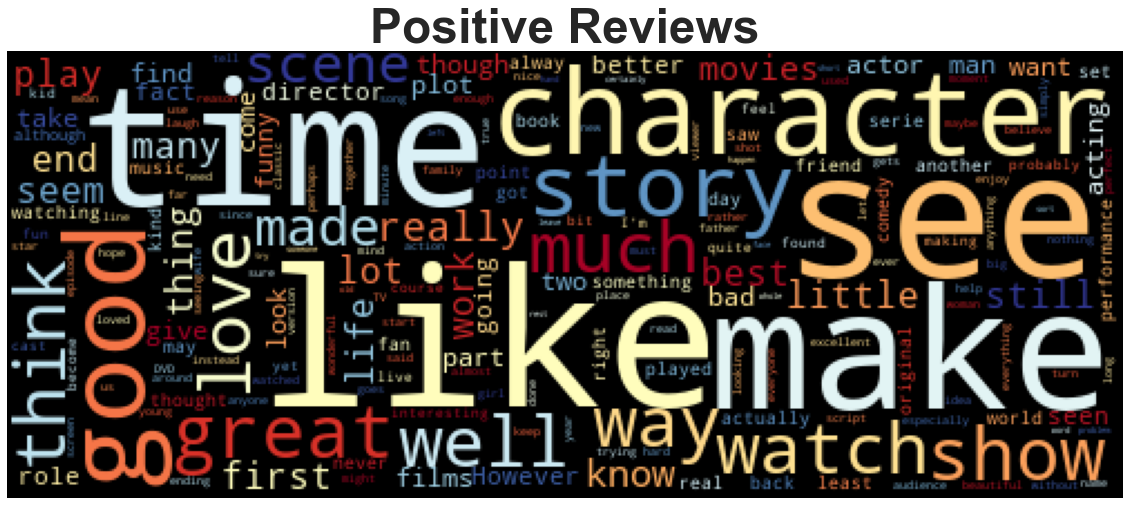

In [81]:
wordcloud(imdb_pos.text.str.cat(), title = 'Positive Reviews')

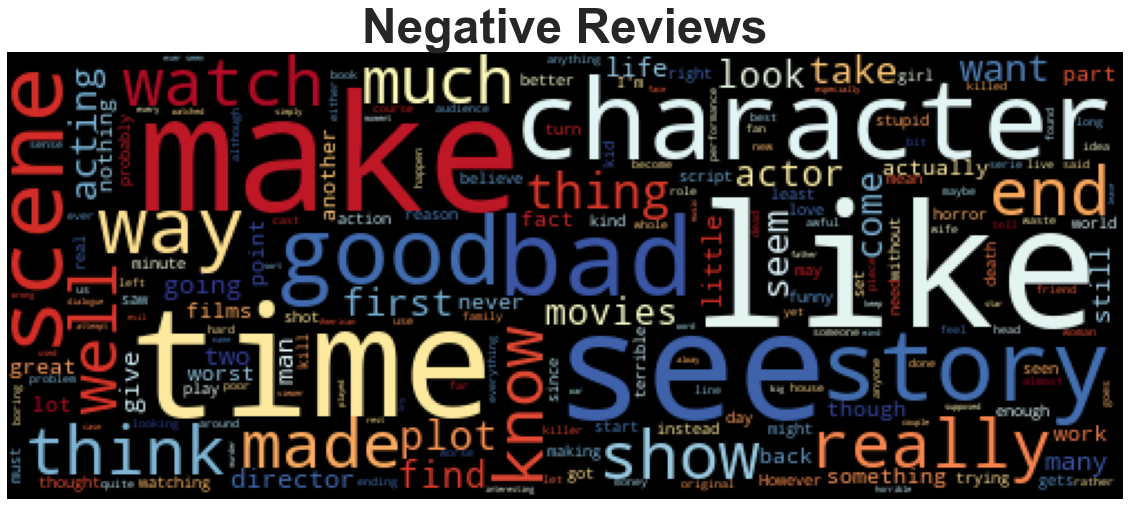

In [82]:
wordcloud(imdb_neg.text.str.cat(), title = 'Negative Reviews')